# Starbucks Capstone Challenge

# **Table of Contents**
1. [Introduction](#intro)
1. [Business Understanding](#business)
1. [Data Preparation](#prepare)
1. [Analisys Data](#EDA)
    1. [Are neighborhoods important in get better housing?](#housing)
    1. [What is the evolution of the different types in Airbnb in Seatle?](#evolution)
    1. [What is the season of the year which it is more occupied?](#season)
1. [Model Data](#model)
1. [Conclusion](#conclusion)

## Introduction
<a id="intro"></a>

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

Data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Problem

My task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.  

Ademas de este analisis de los datos, voy a querer predecir cuando un usuario va a realizar el evento de completar un descuento.

### Solution

Para resolver este problema que nos hemos propuesto, previamente voy a tener que realizar un gran proceso de preprocesamiento y limpieza de los datos, a partir de los datos limpios voy a poder realizar estadisticas de estos y resolver algunas preguntas que tendre.
Y finalmente realizare un modelo predictivo binario (completar o no completar), para poder predicir cuando un usuario va a realizar una oferta por completo. Esto nos ayudara a saber cuando se acaban las ofertas a los clientes para poder proporcionales otras mas adelante.


## Business Understanding
<a id="business"></a>

### Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Vamos a realizar la importancion de las librerias y a cargar los datasets en formato Json.

In [3]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import json

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)


### Portfolio Dataset

Este dataset tiene la informacion de todas las ofertas que se van a usar y su descripcion.

In [130]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)


In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


Como se puede observar este dataset esta compuesto por 10 filas y 6 columnas y no tiene valores nulos.

### Profile Dataset

Este dataset tiene la informacion de todos los clientes y su descripcion.

In [131]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [6]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [5]:
profile.isna().sum()/profile.shape[0]

gender              0.127941
age                 0.000000
id                  0.000000
became_member_on    0.000000
income              0.127941
dtype: float64

Como se puede observar este dataset esta compuesto por 17000 y 5 columnas, ademas contiene valores nulos en las variables gender and income representa el 12.7% del dataset, que coincide el mismo numero de valores nulos, en el apartado de preprocesamiento analizare en profundidad este caso de valores nulos.

### Transcript Dataset

Este dataset tiene la informacion de todas las transacciones de Starbucks en funcion del tiempo.

In [132]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [9]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


Como se puede observar este dataset esta compuesto por 306534 filas y 4 columnas y no tiene valores nulos.

## Data Preparation
<a id="prepare"></a>

#### Clean Nulls
Para empezar voy a realizar el procesamiento de los datos nulos que se habia visto en el dataset *profile* y se tiene que elegir entre imputar esos datos o eliminar esas filas nulas.

In [154]:
profile.isna().sum()/profile.shape[0]

gender              0.127941
age                 0.000000
id                  0.000000
became_member_on    0.000000
income              0.127941
dtype: float64

Como se observa se tiene 12.7% de las filas con valores nulos, voy a examinar esas filas nulas y ver si tiene sentido el resto de columnas para preservar esos valores nulos haciendo imputación o directamente eliminarlos.

In [156]:
profile=profile.dropna()

#### Finding outliers

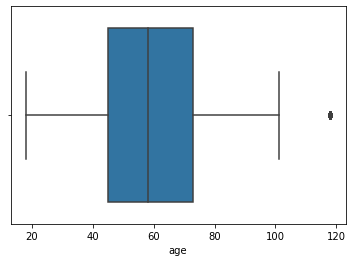

In [7]:
import seaborn as sns
sns.boxplot(x=profile["age"])

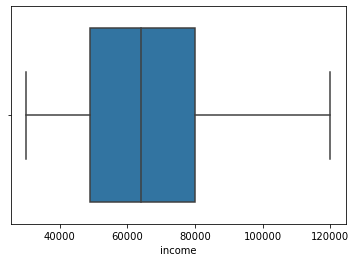

In [11]:
sns.boxplot(x=profile["income"])

#### AAAAAAA

Cuando se ha convertido en miembro¡¡¡¡

In [163]:
transcript["event"].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [164]:
def reward(a):
    if("reward" in a.keys()):
        return a["reward"]
    return None

def amount(a):
    if("amount" in a.keys()):
        return a["amount"]
    return None

def offer_id(a):
    if("offer id" in a.keys()):
        return a["offer id"]
    elif("offer_id" in a.keys()):
        return a["offer_id"]
    return None

transcript["event"]=transcript["event"].map(lambda x: x.replace("offer ",""))
transcript["offer"]=transcript["value"].map(offer_id)
transcript["reward"]=transcript["value"].map(reward)
transcript["amount"]=transcript["value"].map(amount)
transcript=transcript.drop(['value'], axis=1)
transcript

,person,event,time,offer,reward,amount
0,78afa995795e4d85b5d9ceeca43f5fef,received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN
...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,None,NaN,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,None,NaN,9.53
306531,a00058cf10334a308c68e7631c529907,transaction,714,None,NaN,3.61
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,None,NaN,3.53


In [85]:
def count_element(a):
    suma=0
    for key in a.keys():
        if(type(a[key])=="list"):
            suma=suma+len(a[key])
        else:
            suma=suma+1
    return suma

In [88]:
transcript["element"]=transcript["value"].map(count_element)
max(transcript["element"])

2

In [89]:
pp=transcript["value"].values
set().union(*(d.keys() for d in pp))

{'amount', 'offer id', 'offer_id', 'reward'}

## Analisys Data
<a id="EDA"></a>

#### Evento que mas se ha realizado

In [24]:
total=transcript.shape[0]
porc_received=(transcript[transcript["event"]=="received"].shape[0]/total)*100
porc_completed=(transcript[transcript["event"]=="completed"].shape[0]/total)*100
porc_viewed=(transcript[transcript["event"]=="viewed"].shape[0]/total)*100
porc_transaction=(transcript[transcript["event"]=="transaction"].shape[0]/total)*100

<BarContainer object of 4 artists>

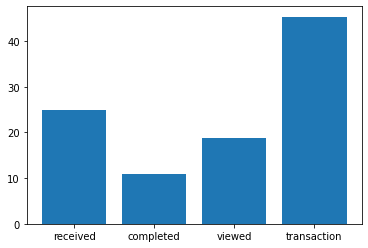

In [28]:
x=["received","completed","viewed","transaction"]
height=[porc_received,porc_completed,porc_viewed,porc_transaction]
plt.bar(x, height)

#### Que oferta es la que mas se ha completado

In [121]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [124]:
completed=transcript[transcript["event"]=="completed"]
merge=pd.merge(portfolio,completed, left_on=['id'], right_on=['offer'], how='left')
merge=merge.groupby(["offer_type","difficulty","duration","reward_x"]).count()["id"].reset_index()
merge

,offer_type,difficulty,duration,reward_x,id
0,bogo,5,5,5,4296
1,bogo,5,7,5,4354
2,bogo,10,5,10,3331
3,bogo,10,7,10,3688
4,discount,7,7,3,5156
5,discount,10,7,2,4017
6,discount,10,10,2,5317
7,discount,20,10,5,3420
8,informational,0,3,0,1
9,informational,0,4,0,1


<BarContainer object of 10 artists>

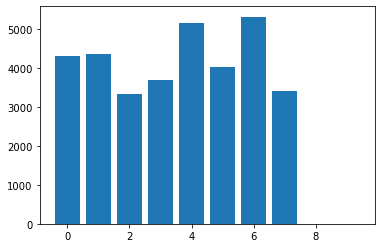

In [127]:
def func(row): 
    return row["offer_type"] +"_"+ str(row["difficulty"]) +"_"+ str(row["duration"])+"_"+ str(row["reward_x"])


merge["name_offer"]=range(0,10)
plt.bar(merge["name_offer"], merge["id"])

#### Range Age en los clientes

#### Tipo de ofertas mas frecuentes por genero

#### Rango income de los clientes

## Model Data
<a id="model"></a>

## Conclusion
<a id="conclusion"></a>